In [173]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics


In [174]:
def wrangle(path, target="temp_max"):
        df = pd.read_csv(path)
        df['date'] = pd.to_datetime(df['date'])
        df['day_of_year'] = df['date'].dt.dayofyear

        df_prophet = df[['date', target]].rename(columns={'date': 'ds', target: 'y'})

        did_rain = [0 if i == 0 else 1 for i in df['precipitation_total']]
        df['did_rain'] = did_rain

        df.replace(-999.0000, np.nan, inplace=True)
        df_prophet.replace(-999.0000, np.nan, inplace=True)

        df.dropna(inplace=True)
        df_prophet.dropna(inplace=True)

        return df, df_prophet


In [175]:
df,df_prophet = wrangle("nasa hackathon/nasa_daily_weather_data.csv",target="wind_speed")
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df_prophet)

06:58:07 - cmdstanpy - INFO - Chain [1] start processing
06:58:09 - cmdstanpy - INFO - Chain [1] done processing


In [176]:
df

,date,temp_max,temp_min,humidity_specific,pressure,precipitation_total,solar_radiation,wind_speed,lat,lon,day_of_year,did_rain
0,1984-01-01,20.63,9.76,6.57,101.57,0.10,3.3170,3.08,30.443917,30.970726,1,1
1,1984-01-02,20.76,8.89,6.17,102.09,0.00,3.4673,2.22,30.443917,30.970726,2,0
2,1984-01-03,21.02,8.98,6.31,102.15,0.07,3.3485,1.62,30.443917,30.970726,3,1
3,1984-01-04,19.04,8.25,6.48,101.79,0.02,3.2179,1.81,30.443917,30.970726,4,1
4,1984-01-05,19.52,7.20,6.05,101.71,0.00,3.5400,1.24,30.443917,30.970726,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15264,2025-10-16,31.35,17.43,9.24,101.10,0.00,5.2716,2.42,30.443917,30.970726,289,0
15265,2025-10-17,31.40,17.22,8.86,101.34,0.00,5.2939,2.39,30.443917,30.970726,290,0
15266,2025-10-18,32.16,16.60,8.77,101.50,0.00,5.2522,2.28,30.443917,30.970726,291,0
15267,2025-10-19,32.80,17.85,9.30,101.35,0.00,5.1821,2.07,30.443917,30.970726,292,0


In [177]:
# --- 4. Make Future Predictions ---
# Create a dataframe that extends into the future to our target date.
future = model.make_future_dataframe(periods=574) # Go past 2026-02-05
forecast = model.predict(future)

Forecast for 2025-09-15:
              ds      yhat  yhat_lower  yhat_upper
15284 2025-11-05  2.408055    1.445327    3.319136
------------------------------
Plotting the forecast...


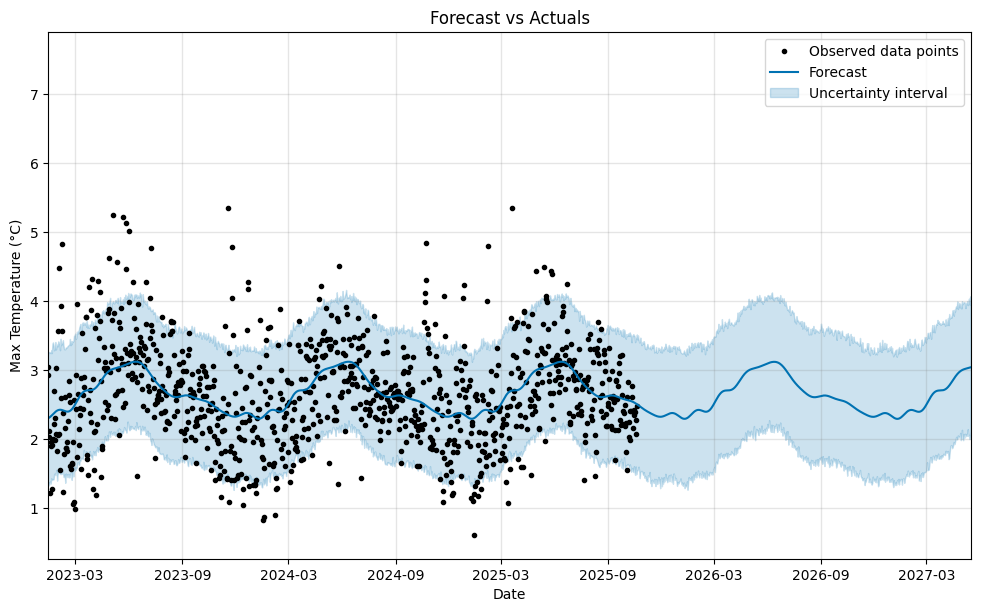

Plotting the model components...


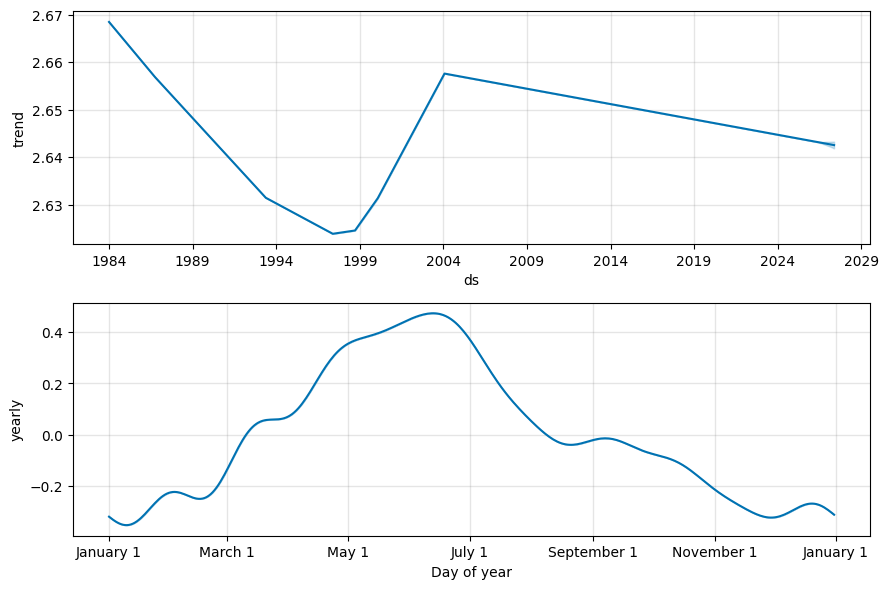

In [178]:

forecast_date = forecast[forecast['ds'] == '2025-11-05']
print(f"Forecast for 2025-09-15:")
print(forecast_date[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
# yhat: The predicted temperature.
# yhat_lower/yhat_upper: The uncertainty interval. The model is confident the true value will fall in this range.
print("-" * 30)


# B) Plot the entire forecast
# This is the best way to see how the model's prediction fits the historical data.
print("Plotting the forecast...")
fig1 = model.plot(forecast)
start, end = forecast['ds'].min(), forecast['ds'].max()
plt.xlim(end - 0.1 * (end-start) , end)
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Max Temperature (°C)')
plt.legend()
plt.show()

# C) Plot the model components
# This is the KEY to interpreting Prophet. It shows what patterns the model learned.
print("Plotting the model components...")
fig2 = model.plot_components(forecast)
plt.show()
# You will see:
# 1. Trend: The overall long-term direction of the temperature.
# 2. Yearly: The seasonal pattern learned by the model. This should look like a wave, peaking in summer and bottoming out in winter.

In [164]:
#Uncertainty (Confidence Interval) 
forecast['uncertainty'] = forecast['yhat_upper'] - forecast['yhat_lower']
print("Mean uncertainty:", forecast['uncertainty'].mean())


Mean uncertainty: 4.710240312154167


In [165]:
trend_strength = forecast['trend'].std()
seasonality_strength = forecast['weekly'].std() if 'weekly' in forecast else 0
print("Trend strength:", trend_strength)
print("Weekly seasonality strength:", seasonality_strength)


Trend strength: 0.5371237159790375
Weekly seasonality strength: 0


In [166]:
df_cv = cross_validation(
    model=model,
    initial='7300 days',   # first 20 years for training
    period='365 days',     # evaluate yearly
    horizon='180 days',    # predict 1 year ahead
    parallel="processes"   # use multiple cores for speed
)

df_p = performance_metrics(df_cv)

                          horizon         mse        rmse         mae  \
count                         163  163.000000  163.000000  163.000000   
mean             99 days 00:00:00    2.514331    1.544918    1.225274   
std    47 days 04:45:21.352846324    1.248880    0.358256    0.294266   
min              18 days 00:00:00    1.279503    1.131151    0.902595   
25%              58 days 12:00:00    1.631953    1.277479    1.014863   
50%              99 days 00:00:00    2.079555    1.442066    1.112844   
75%             139 days 12:00:00    2.748501    1.657857    1.356795   
max             180 days 00:00:00    5.730672    2.393882    1.912021   

             mape       mdape       smape    coverage  
count  163.000000  163.000000  163.000000  163.000000  
mean     0.060941    0.052145    0.060942    0.875627  
std      0.021893    0.019255    0.021302    0.081033  
min      0.040080    0.032474    0.040472    0.691919  
25%      0.045559    0.039409    0.045861    0.845960  
50%   

In [167]:
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,163,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,99 days 00:00:00,2.514331,1.544918,1.225274,0.060941,0.052145,0.060942,0.875627
std,47 days 04:45:21.352846324,1.248880,0.358256,0.294266,0.021893,0.019255,0.021302,0.081033
min,18 days 00:00:00,1.279503,1.131151,0.902595,0.040080,0.032474,0.040472,0.691919
25%,58 days 12:00:00,1.631953,1.277479,1.014863,0.045559,0.039409,0.045861,0.845960
50%,99 days 00:00:00,2.079555,1.442066,1.112844,0.052607,0.043687,0.053355,0.904040
75%,139 days 12:00:00,2.748501,1.657857,1.356795,0.066796,0.060980,0.066787,0.931818
max,180 days 00:00:00,5.730672,2.393882,1.912021,0.117437,0.106812,0.116655,0.957071
